In [1]:
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import pandas as pd

In [2]:
!pwd 

/src/drone_causality/quadrant_wise_dataset


In [3]:
# ── CONFIG ──────────────────────────────────────────────
diff_dataset_root = "mix_goal_heights_diff"       # input: difference images (black bg + markers)
output_root       = "mix_goal_heights_diff_rgba"   # output: RGBA images with transparent background
file_ending       = "png"
file_name         = "data_out.csv"

# Pixels with grayscale value > this are considered part of a marker
BG_THRESHOLD      = 15

# Large dilation kernel to merge all pixels within each marker box
# into one connected blob before contour detection.
# Increase if markers still have holes; decrease if the two boxes start merging.
DILATION_KERNEL   = 25

In [6]:
!mkdir mix_goal_heights_diff_rgba



In [4]:
def create_foreground_mask(img_bgr, threshold=BG_THRESHOLD, dilation_size=DILATION_KERNEL):
    """
    Create a mask that covers the ENTIRE marker box region, including
    the internal black pixels of the ArUco pattern.
    
    Steps:
      1. Threshold to find any non-black pixels
      2. Heavy dilation to merge all parts of each marker into one blob
         (bridges the gaps from internal black pixels)
      3. Find external contours of each blob
      4. Fill contours -> solid region covering the whole box
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Heavy dilation to connect all white/gray pixels within each box
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilation_size, dilation_size))
    dilated = cv2.dilate(mask, kernel, iterations=1)

    # Find external contours on the dilated (merged) blobs
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill contours to get solid box regions
    filled = np.zeros_like(mask)
    cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)

    return filled


def bgr_to_rgba_with_mask(img_bgr, mask):
    """
    Convert BGR image to RGBA where alpha = foreground mask.
    Background becomes transparent; entire marker box stays opaque.
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgba = np.dstack([img_rgb, mask])  # H x W x 4
    return rgba

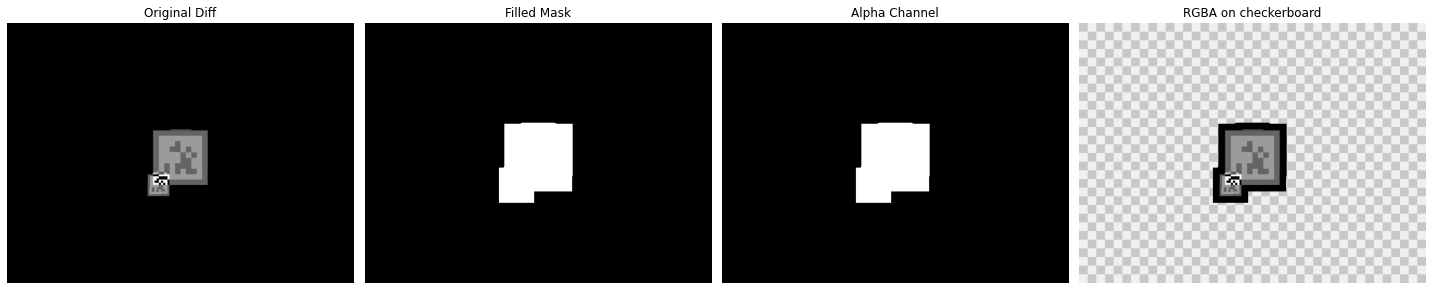

Mask covers 17656 pixels out of 307200 total
Number of contours (boxes) found: 1


In [5]:
# ── QUICK VISUAL CHECK ─────────────────────────────────
from matplotlib import pyplot as plt

sample_path = f"{diff_dataset_root}/1/Image1.png"
sample = cv2.imread(sample_path)
mask = create_foreground_mask(sample)
rgba = bgr_to_rgba_with_mask(sample, mask)

# Checkerboard to visualise transparency
checker = np.zeros((rgba.shape[0], rgba.shape[1], 3), dtype=np.uint8)
for r in range(0, checker.shape[0], 16):
    for c in range(0, checker.shape[1], 16):
        if (r // 16 + c // 16) % 2 == 0:
            checker[r:r+16, c:c+16] = 200
        else:
            checker[r:r+16, c:c+16] = 240
alpha = rgba[:, :, 3:4] / 255.0
vis = (rgba[:, :, :3] * alpha + checker * (1 - alpha)).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)); axes[0].set_title("Original Diff")
axes[1].imshow(mask, cmap='gray');                        axes[1].set_title("Filled Mask")
axes[2].imshow(rgba[:, :, 3], cmap='gray');               axes[2].set_title("Alpha Channel")
axes[3].imshow(vis);                                      axes[3].set_title("RGBA on checkerboard")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Mask covers {(mask > 0).sum()} pixels out of {mask.size} total")
print(f"Number of contours (boxes) found: {len(cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])}")

In [7]:
# ── PROCESS ENTIRE DATASET ─────────────────────────────
num_dirs = len(os.listdir(diff_dataset_root))

for i in tqdm(range(num_dirs), desc="Directories"):
    directory = i + 1
    src_dir = f"{diff_dataset_root}/{directory}"
    dst_dir = f"{output_root}/{directory}"
    os.makedirs(dst_dir, exist_ok=True)

    # Copy CSV labels
    csv_src = os.path.join(src_dir, file_name)
    if os.path.exists(csv_src):
        labels = pd.read_csv(csv_src)
        labels.to_csv(os.path.join(dst_dir, file_name), index=False)

    image_files = [fn for fn in os.listdir(src_dir) if fn.endswith(f".{file_ending}")]
    n_images = len(image_files)

    for j in range(1, n_images + 1):
        img_path = f"{src_dir}/Image{j}.png"
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue

        mask = create_foreground_mask(img_bgr)
        rgba = bgr_to_rgba_with_mask(img_bgr, mask)

        # Save as RGBA PNG via PIL
        Image.fromarray(rgba, 'RGBA').save(f"{dst_dir}/Image{j}.png")

print("Done!")

Directories: 100%|██████████| 334/334 [18:37<00:00,  3.35s/it]

Done!


In [ ]:
# ── VERIFY ─────────────────────────────────────────────
out_img = Image.open(f"{output_root}/1/Image1.png")
print(f"Mode: {out_img.mode}, Size: {out_img.size}")

out_arr = np.array(out_img)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(out_arr[:, :, :3]); axes[0].set_title("RGB channels")
axes[1].imshow(out_arr[:, :, 3], cmap='gray'); axes[1].set_title("Alpha channel")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()